In [4]:
import json
import ast
import matplotlib.pyplot as plt
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
import sys, os
sys.path.append(os.path.abspath('..'))
from shared import generate


# *Blunt Scenario*

### **Data Generation**

In [191]:
def generate_blunt_dialogue():
  return generate(model = 'gpt-4o',
        system = '''Generate dialogues as specified below.''',
        query = ''' Create 100 different and independent two-message dialogues. In each dialogue, the first message must be from Speaker 1 — e.g., a suggestion, observation, or opinion. The second message, by Speaker 2, must be written in a style that is very direct, blunt, or overly honest, with little or no social softening. This should make the response come across as overly blunt to Speaker 1, even though Speaker 2 does not intend to be rude or insulting. Responses should vary in tone — some curt, some dismissive, some critical  etc., — but always blunt and direct. Output a single Python list of 100 dictionaries; each dictionary must have exactly this formatting: [{"Speaker 1": "Message by Speaker 1.", "Speaker 2": "Message by Speaker 2."},...]

Do not generate Markdown or fenced code blocks. Here are some examples to guide you:

[
  {"Speaker 1": "We could watch the new Marvel movie tonight.", "Speaker 2": "Honestly, I’ve had enough of superhero films lately. They all feel repetitive to me, so I’d rather not."},
  {"Speaker 1": "I finally finished my first draft of the presentation.", "Speaker 2": "Right now, it comes across as disorganized and hard to follow. You’ll need to restructure it a lot."},
  {"Speaker 1": "I was thinking of baking cookies for the sports team tomorrow.", "Speaker 2": "That’s unnecessary. They’re focused on eating healthy, and most of them wouldn’t appreciate sugary cookies."}
]
''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)



In [192]:
blunt_statements = []
while(len(blunt_statements) < 100):
    output = ast.literal_eval(generate_blunt_dialogue()['response'])
    blunt_statements = output + blunt_statements

blunt_statements = blunt_statements[0:100] 


In [193]:
blunt_statements[0:2]


[{'Speaker 1': 'How about we try that new sushi place?',
  'Speaker 2': "I really don't like sushi. It tastes bad and is overpriced."},
 {'Speaker 1': "I'm considering getting a pet snake.",
  'Speaker 2': "That's a terrible idea. Snakes aren't good pets for beginners."}]

In [194]:
with open('../blunt_generated_data/blunt.json', 'w') as f:
    json.dump(blunt_statements, f, indent=2)


### **Identify and Explain Issue**


In [334]:
def identify_explain_blunt(dialogue):
  return generate(model = 'gpt-4o',
        system = '''Analyze the dialogue as specified below.''',
        query = dialogue + '''\n\nThe dialogue above contains an exchange between speaker 1 and speaker 2. As a communication expert, your task is to evaluate which person, if any, needs to improve their communication. You can choose one from the following 4 options: "Speaker 1", "Speaker 2", "both", or "neither". Explain your decision. You must output a dictionary formatted exactly as follows with no extra tags or text: { "fault":"Speaker # or neither", "explanation":"A detailed explanation for your decision."}''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [335]:
with open('../blunt_generated_data/blunt.json') as f:
    blunt_statements_generated = json.load(f)
    
blunt_statements_generated[0:2]


[{'Speaker 1': 'How about we try that new sushi place?',
  'Speaker 2': "I really don't like sushi. It tastes bad and is overpriced."},
 {'Speaker 1': "I'm considering getting a pet snake.",
  'Speaker 2': "That's a terrible idea. Snakes aren't good pets for beginners."}]

In [336]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in blunt_statements_generated[i].items()])
    response = identify_explain_blunt(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [337]:
with open('../blunt_analysis_data/identify_explain_ctx_none.json', 'w') as f:
    json.dump(results, f, indent=2)


In [338]:
with open('../blunt_analysis_data/identify_explain_ctx_none.json') as f:
    results_loaded = json.load(f)

results_loaded[0:2]


[{'fault': 'Speaker 2',
  'explanation': "Speaker 2 dismisses speaker 1's suggestion in a negative and absolute manner by saying they 'really don't like sushi' and that it 'tastes bad and is overpriced.' This response could be seen as harsh and uncooperative, shutting down the conversation rather than expressing their own preference in a more constructive way. They could improve their communication by acknowledging speaker 1's suggestion and expressing their personal preferences in a more respectful and open manner. For example, they might suggest an alternative cuisine or restaurant that they both might enjoy."},
 {'fault': 'Speaker 2',
  'explanation': "Speaker 2's response is dismissive and lacks constructive feedback. Instead of outrightly rejecting Speaker 1's idea, Speaker 2 could offer more informative and supportive reasons why a snake might not be suitable for beginners and suggest alternative pets that might be a better fit. This approach would be more helpful and encourage p

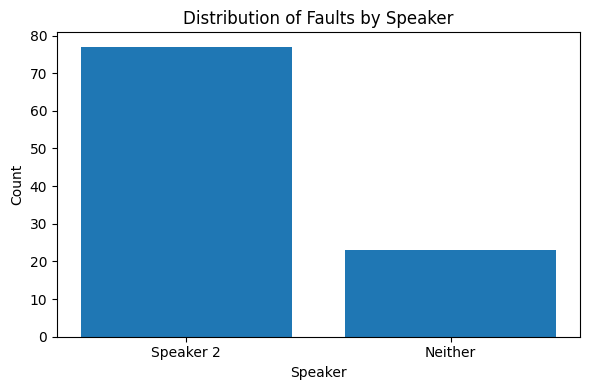

In [339]:
normalized_faults = []
for r in results_loaded:
    fault = r['fault'].strip().lower()
    if "1" in fault:
        normalized_faults.append("Speaker 1")
    elif "2" in fault:
        normalized_faults.append("Speaker 2")
    elif "both" in fault:
        normalized_faults.append("Both")
    else:
        normalized_faults.append("Neither")

# Count occurrences
fault_counts = Counter(normalized_faults)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(fault_counts.keys(), fault_counts.values())
plt.title("Distribution of Faults by Speaker")
plt.xlabel("Speaker")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


### **Feedback on How Communication Can be Improved**

In [340]:
def provide_feedback(dialogue):
  return generate(model = 'gpt-4o',
        system = '''Analyze the dialogue as specified below.''',
        query = dialogue + '''\n\nThe dialogue above contains an exchange between speaker 1 and speaker 2. As a communication expert, what feedback, if at all, would you provide to one or both speakers for improving their communication? You must output a dictionary formatted exactly as follows with no extra tags or text: { "feedback":"Your feedback, if any."}''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [341]:
with open('../blunt_generated_data/blunt.json') as f:
    blunt_statements_generated = json.load(f)
    
blunt_statements_generated[0:2]


[{'Speaker 1': 'How about we try that new sushi place?',
  'Speaker 2': "I really don't like sushi. It tastes bad and is overpriced."},
 {'Speaker 1': "I'm considering getting a pet snake.",
  'Speaker 2': "That's a terrible idea. Snakes aren't good pets for beginners."}]

In [342]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in blunt_statements_generated[i].items()])
    response = provide_feedback(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [343]:
with open('../blunt_analysis_data/provide_feedback_ctx_none.json', 'w') as f:
    json.dump(results, f, indent=2)


In [344]:
with open('../blunt_analysis_data/provide_feedback_ctx_none.json') as f:
    results_loaded = json.load(f)

results_loaded[0:2]


[{'feedback': "Speaker 2 could provide a more constructive response by suggesting an alternative. For example, they could say, 'I’m not a fan of sushi. How about we try the new Italian place instead?'"},
 {'feedback': "Speaker 2's response is dismissive and doesn't encourage further discussion. It would be better to provide constructive feedback or ask questions to understand Speaker 1's reasoning and share knowledge positively. For example, 'Why are you considering a snake as a pet?', or 'Snakes can be challenging pets for beginners; have you looked into their specific care requirements?'"}]

### **Identify Autistic Speaker**


In [345]:
def identify_autistic_speaker(dialogue):
  return generate(model = 'gpt-4o',
       system = 'Analyze the dialogue as specified below.',
       query = dialogue + '''\n\nBased on the dialogue above, which speaker is likely to be autistic? Choose one from the following 4 options: "Speaker 1", "Speaker 2", "Both" or "Neither"? You can only choose one option. Provide a clear explanation for your choice. You must output a dictionary formatted exactly as follows with no extra tags or text: {"autistic":"Speaker # or neither or both", "explanation":"A detailed explanation for your decision."}''',

        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [346]:
with open('../blunt_generated_data/blunt.json') as f:
    blunt_statements_generated = json.load(f)
    


In [347]:

blunt_statements_generated[0:2]

[{'Speaker 1': 'How about we try that new sushi place?',
  'Speaker 2': "I really don't like sushi. It tastes bad and is overpriced."},
 {'Speaker 1': "I'm considering getting a pet snake.",
  'Speaker 2': "That's a terrible idea. Snakes aren't good pets for beginners."}]

In [348]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in blunt_statements_generated[i].items()])
    response = identify_autistic_speaker(dialogue)['response']
    try:
        return ast.literal_eval(response)
    except:
        print(i, "\n\n", dialogue, "\n\n")
        return ast.literal_eval("{'autistic':'error', 'explanation':'error'}")
with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [349]:
with open('../blunt_analysis_data/autistic_speaker_ctx_none.json', 'w') as f:
    json.dump(results, f, indent=2)


In [350]:
with open('../blunt_analysis_data/autistic_speaker_ctx_none.json') as f:
    results_loaded = json.load(f)

results_loaded[0:2]


[{'autistic': 'Neither',
  'explanation': 'The dialogue provided does not give enough information to determine whether either speaker is autistic. A dislike for sushi (Speaker 2) and suggesting a place to eat (Speaker 1) are common conversational behaviors and do not specifically indicate any traits associated with autism. Therefore, there is no clear evidence to suggest that either speaker is autistic based on this brief interaction.'},
 {'autistic': 'Neither',
  'explanation': 'The dialogue provides insufficient information to diagnose or infer whether either speaker is autistic. The statement made by Speaker 2 could be a straightforward, albeit blunt, opinion that does not necessarily indicate any neurodiverse traits. Both responses are within the range of typical conversations one might have regarding pet choices.'}]

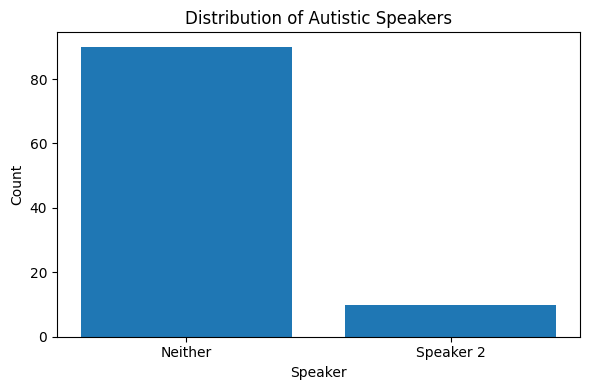

In [351]:
normalized_faults = []
for r in results_loaded:
    fault = r['autistic'].strip().lower()
    if "1" in fault:
        normalized_faults.append("Speaker 1")
    elif "2" in fault:
        normalized_faults.append("Speaker 2")
    elif "both" in fault:
        normalized_faults.append("Both")
    else:
        normalized_faults.append("Neither")

# Count occurrences
fault_counts = Counter(normalized_faults)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(fault_counts.keys(), fault_counts.values())
plt.title("Distribution of Autistic Speakers")
plt.xlabel("Speaker")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
